In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import yaml

# 1. Dataset

## 1.1. Carga de datos

Cargamos los datos que obtuvimos del clustering con los equipos, así como los resultados de los partidos.

In [2]:
teams_df = pd.read_csv('../models/teams_EM.csv')
teams_df

,Unnamed: 0,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO,PC1,PC2,cluster
0,0,CRO,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98,-3.007976,4.226142,3
1,1,CZE,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40,5.047346,0.364696,0
2,2,DEN,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,-3.174269,0.759901,3
3,3,ESP,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,-0.934444,-0.324208,1
4,4,FRA,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,-4.118907,1.369064,3
5,5,GER,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72,-1.206175,0.056285,1
6,6,HUN,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79,-0.210540,-1.356587,4
7,7,MNE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,0.477307,-1.030249,4
8,8,NED,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81,-2.727188,-1.817280,1
9,9,NOR,35,9,36,14,59,40,44,15,47,18,0,0,33,50,0,18,148,44,34,33,24,75,-5.388616,-3.702451,2


In [3]:
with open('../data/matches.yml', 'r', encoding='utf8') as f:
    matches = yaml.safe_load(f)

## 1.2. Funciones de utilidad

Funciones que serán útiles al procesar los datos. En este caso definimos una para convertir el nombre del país a su abreviatura.

In [4]:
def country_abbr(country_name):
    return {
        'Alemania': 'GER',
        'Croacia': 'CRO',
        'Dinamarca': 'DEN',
        'Eslovenia': 'SLO',
        'España': 'ESP',
        'Francia': 'FRA',
        'Hungría': 'HUN',
        'Montenegro': 'MNE',
        'Noruega': 'NOR',
        'Países Bajos': 'NED',
        'Polonia': 'POL',
        'República Checa': 'CZE',
        'Rumania': 'ROU',
        'Rusia': 'RUS',
        'Serbia': 'SRB',
        'Suecia': 'SWE'
    }[country_name]

## 1.3. Conjuntos de entrenamiento y test

Inicialmente, y según lo que dice el enunciado, vamos a dejar los 24 partidos de la primera fase para la validación del modelo. Por tanto, nos quedamos con los otros 23 partidos de las otras fases para el entrenamiento.

Sería conveniente tener más datos en el entrenamiento, pero vamos a dejarlo así para una prueba inicial.

Para cada conjunto de datos necesitamos saber qué equipos conforman cada partido y cuál de los dos fue el ganador. Las etiquetas para el resultado se han definido como:
   - **-1**: Resultado no definido (el partido no se ha jugado)
   - **0**: Empate
   - **1**: Gana el primer equipo
   - **2**: Gana el segundo equipo

In [5]:
train_matches = []
test_matches = []
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            teamA, teamB = match.keys()
            
            if match[teamA] == match[teamB]:
                winner = 0
            else:
                winner = 1 if match[teamA] > match[teamB] else 2

            if phase == 'first':
                test_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            else:
                train_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            
print("Train:", train_matches)
print()
print("Test:", test_matches)

Train: [['MNE', 'RUS', 2], ['FRA', 'ESP', 1], ['FRA', 'RUS', 0], ['DEN', 'SWE', 1], ['MNE', 'SWE', 1], ['DEN', 'ESP', 1], ['MNE', 'ESP', 0], ['FRA', 'SWE', 1], ['DEN', 'RUS', 1], ['CRO', 'ROU', 1], ['NED', 'NOR', 2], ['HUN', 'GER', 2], ['CRO', 'NOR', 2], ['NED', 'GER', 1], ['HUN', 'ROU', 1], ['NED', 'ROU', 1], ['CRO', 'GER', 1], ['HUN', 'NOR', 2], ['RUS', 'NED', 1], ['FRA', 'CRO', 1], ['NOR', 'DEN', 1], ['CRO', 'DEN', 1], ['FRA', 'NOR', 2]]

Test: [['FRA', 'MNE', 1], ['DEN', 'SLO', 1], ['SLO', 'FRA', 2], ['MNE', 'DEN', 2], ['MNE', 'SLO', 1], ['FRA', 'DEN', 1], ['RUS', 'ESP', 1], ['SWE', 'CZE', 1], ['CZE', 'RUS', 2], ['ESP', 'SWE', 0], ['ESP', 'CZE', 1], ['RUS', 'SWE', 1], ['HUN', 'CRO', 2], ['NED', 'SRB', 2], ['SRB', 'HUN', 2], ['CRO', 'NED', 1], ['SRB', 'CRO', 2], ['NED', 'HUN', 1], ['ROU', 'GER', 2], ['NOR', 'POL', 1], ['POL', 'ROU', 2], ['GER', 'NOR', 2], ['GER', 'POL', 0], ['ROU', 'NOR', 2]]


# 2. Modelo de predicción

Tenemos que definir qué datos se usarán como entrada para el modelo de predicción. Puesto que el objetivo es conocer el resultado del partido dados dos equipos, consideramos que el modelo de predicción tiene que tomar como entrada un vector de características por cada equipo que sea representativo de su "modo de juego". De esta manera podremos utilizar la caracterización de ambos equipos para predecir el resultado.

Debido a que ya realizamos un análisis de las variables en el trabajo de clustering, hemos considerado tres opciones:
   - Utilizar los resultados del análisis de **componentes principales** que se realizó en el trabajo de clustering, junto con el **cluster** obtenido para cada equipo. Tendríamos de esta manera 3 variables para cada uno de los dos equipos que juegan el partido.
   - Utilizar **todas las variables** de nuevo (después de haber eliminado las que no eran útiles), junto con el **cluster** obtenido. Podría dar buenos resultados ya que dejaríamos al modelo de predicción elegir en cierta manera qué variables son más influyentes para la predicción.
   - Realizar un nuevo **análisis de componentes principales** sobre las variables del caso anterior.

Vamos a probar las tres opciones, pero previamente vamos a definir más funciones de utilidad.

In [6]:
def get_match_features(team_features):
    '''
        Duplicamos el vector de características para el primer y el segundo equipo
    '''
    return [*[f'A_{f}' for f in team_features], *[f'B_{f}' for f in team_features]]
    

def generate_data(matches, teams_df, features, augment=False):
    '''
        Generación de un DataFrame que contenga las características elegidas
        para los dos equipos que juegan cada partido.
        
        El parámetro 'augment' permite duplicar los partidos cambiando el orden
        de los equipos (e invirtiendo el resultado). Lo consideramos una forma
        de "data augmentation" para darle robusted al modelo y además compensar
        el volumen tan limitado de datos.
    '''
    data = []
    for match in matches:
        # El partido puede incluir el resultado o no (si es un partido no jugado)
        if len(match) == 3:
            teamA, teamB, result = match
        elif len(match) == 2:
            teamA, teamB = match
            result = -1
        
        # Obtenemos las características deseadas de cada equipo
        teamA_data = teams_df.loc[teams_df['Team'] == teamA][features].values.tolist()[0]
        teamB_data = teams_df.loc[teams_df['Team'] == teamB][features].values.tolist()[0]
        
        # Añadimos el partido (junto con las características de los dos equipos) al dataframe
        data.append([teamA, teamB, *teamA_data, *teamB_data, result])
        
        if augment:
            data.append([
                teamB, teamA,
                *teamB_data, *teamA_data,
                {-1:-1, 0: 0, 1: 2, 2: 1}[result] # Inversión del resultado
            ])
    
    match_features = get_match_features(features)
    return pd.DataFrame(data=data,
                        columns=['teamA', 'teamB', *match_features, 'result'])


## 2.1. Dos componentes principales + clúster

In [7]:
team_features = ['PC1', 'PC2', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

train_df

,teamA,teamB,A_PC1,A_PC2,A_cluster,B_PC1,B_PC2,B_cluster,result
0,MNE,RUS,0.477307,-1.030249,4.0,-1.043192,0.002938,1.0,2
1,RUS,MNE,-1.043192,0.002938,1.0,0.477307,-1.030249,4.0,1
2,FRA,ESP,-4.118907,1.369064,3.0,-0.934444,-0.324208,1.0,1
3,ESP,FRA,-0.934444,-0.324208,1.0,-4.118907,1.369064,3.0,2
4,FRA,RUS,-4.118907,1.369064,3.0,-1.043192,0.002938,1.0,0
5,RUS,FRA,-1.043192,0.002938,1.0,-4.118907,1.369064,3.0,0
6,DEN,SWE,-3.174269,0.759901,3.0,-0.262189,2.119723,1.0,1
7,SWE,DEN,-0.262189,2.119723,1.0,-3.174269,0.759901,3.0,2
8,MNE,SWE,0.477307,-1.030249,4.0,-0.262189,2.119723,1.0,1
9,SWE,MNE,-0.262189,2.119723,1.0,0.477307,-1.030249,4.0,2


In [8]:
X_train = train_df[match_features]
Y_train = train_df['result']

X_test = test_df[match_features]
Y_test = test_df['result']

### 2.1.1. k-NN

Probamos un clasificador basado en los 'k' vecinos más cercanos. Vamos a estudiar primero la parametrización del algoritmo para ver qué sería lo óptimo en este caso.

In [9]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

best_params = None
best_accuracy = 0

for k in range(2, 15):
    for weights in ['uniform', 'distance']:
        print(f"k-NN (k={k}, weights='{weights}')")
        
        clf = neighbors.KNeighborsClassifier(k, weights=weights)
        clf.fit(X_train, Y_train)
        
        y_pred = clf.predict(X_test)
        
        conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
        accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
        
        if best_params is None or accuracy > best_accuracy:
            best_params = (k, weights)
            best_accuracy = accuracy

print(f"Best accuracy was {accuracy}, with k={best_params[0]} and weights='{best_params[1]}'")

k-NN (k=2, weights='uniform')
k-NN (k=2, weights='distance')
k-NN (k=3, weights='uniform')
k-NN (k=3, weights='distance')
k-NN (k=4, weights='uniform')
k-NN (k=4, weights='distance')
k-NN (k=5, weights='uniform')
k-NN (k=5, weights='distance')
k-NN (k=6, weights='uniform')
k-NN (k=6, weights='distance')
k-NN (k=7, weights='uniform')
k-NN (k=7, weights='distance')
k-NN (k=8, weights='uniform')
k-NN (k=8, weights='distance')
k-NN (k=9, weights='uniform')
k-NN (k=9, weights='distance')
k-NN (k=10, weights='uniform')
k-NN (k=10, weights='distance')
k-NN (k=11, weights='uniform')
k-NN (k=11, weights='distance')
k-NN (k=12, weights='uniform')
k-NN (k=12, weights='distance')
k-NN (k=13, weights='uniform')
k-NN (k=13, weights='distance')
k-NN (k=14, weights='uniform')
k-NN (k=14, weights='distance')
Best accuracy was 0.875, with k=4 and weights='uniform'


In [10]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(4, weights='uniform')
clf.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [11]:
y_pred = clf.predict(X_test)
test_df['knn'] = y_pred

test_df[['teamA', 'teamB', 'result', 'knn']]

,teamA,teamB,result,knn
0,FRA,MNE,1,1
1,DEN,SLO,1,1
2,SLO,FRA,2,2
3,MNE,DEN,2,2
4,MNE,SLO,1,1
5,FRA,DEN,1,1
6,RUS,ESP,1,1
7,SWE,CZE,1,1
8,CZE,RUS,2,2
9,ESP,SWE,0,1


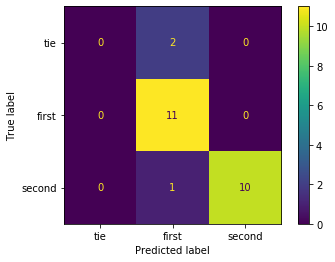

Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.79      1.00      0.88        11
           2       1.00      0.91      0.95        11

    accuracy                           0.88        24
   macro avg       0.60      0.64      0.61        24
weighted avg       0.82      0.88      0.84        24



c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [12]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(
    clf, X_test, Y_test,
    labels=[0, 1, 2],
    display_labels=['tie', 'first', 'second'],
    #normalize='true'
)
plt.show()

conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

from sklearn.metrics import classification_report
print(str(classification_report(y_true=Y_test, y_pred=y_pred)))

### 2.1.2. SVM


In [13]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC()

In [14]:
y_pred = clf.predict(X_test)
test_df['svm'] = y_pred

test_df[['teamA', 'teamB', 'result', 'svm']]

,teamA,teamB,result,svm
0,FRA,MNE,1,1
1,DEN,SLO,1,1
2,SLO,FRA,2,2
3,MNE,DEN,2,2
4,MNE,SLO,1,1
5,FRA,DEN,1,1
6,RUS,ESP,1,1
7,SWE,CZE,1,1
8,CZE,RUS,2,2
9,ESP,SWE,0,1


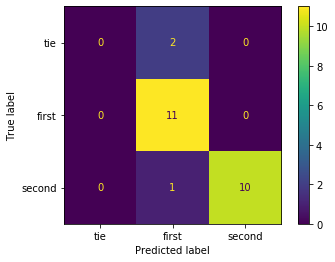

Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.79      1.00      0.88        11
           2       1.00      0.91      0.95        11

    accuracy                           0.88        24
   macro avg       0.60      0.64      0.61        24
weighted avg       0.82      0.88      0.84        24



c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [15]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(
    clf, X_test, Y_test,
    labels=[0, 1, 2],
    display_labels=['tie', 'first', 'second'],
    #normalize='true'
)
plt.show()

conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

from sklearn.metrics import classification_report
print(str(classification_report(y_true=Y_test, y_pred=y_pred)))

## 2.2. Todas las variables + clúster

In [16]:
team_features = ['7mPGoals', '7mPMissed', '6mCGoals', '6mCMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'FTOGoals', 'FTOMissed', '9mGoals', '9mMissed', 'RC', '2M', 'AS', 'R7', 'ST', 'BS', 'P7', 'TO', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

train_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,A_FBGoals,A_FBMissed,A_FTOGoals,A_FTOMissed,A_9mGoals,A_9mMissed,A_RC,A_2M,A_AS,A_R7,A_ST,A_BS,A_P7,A_TO,A_cluster,B_7mPGoals,B_7mPMissed,B_6mCGoals,B_6mCMissed,B_WingGoals,B_WingMissed,B_BTGoals,B_BTMissed,B_FBGoals,B_FBMissed,B_FTOGoals,B_FTOMissed,B_9mGoals,B_9mMissed,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result
0,MNE,RUS,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,2
1,RUS,MNE,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,1
2,FRA,ESP,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,1
3,ESP,FRA,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,2
4,FRA,RUS,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,0
5,RUS,FRA,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,0
6,DEN,SWE,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
7,SWE,DEN,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,2
8,MNE,SWE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
9,SWE,MNE,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,2


In [17]:
X_train = train_df[match_features]
Y_train = train_df['result']

X_test = test_df[match_features]
Y_test = test_df['result']

### 2.2.1. k-NN

Probamos un clasificador basado en los 'k' vecinos más cercanos. Vamos a estudiar primero la parametrización del algoritmo para ver qué sería lo óptimo en este caso.

In [18]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

best_params = None
best_accuracy = 0

for k in range(2, 15):
    for weights in ['uniform', 'distance']:
        print(f"k-NN (k={k}, weights='{weights}')")
        
        clf = neighbors.KNeighborsClassifier(k, weights=weights)
        clf.fit(X_train, Y_train)
        
        y_pred = clf.predict(X_test)
        
        conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
        accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
        
        if best_params is None or accuracy > best_accuracy:
            best_params = (k, weights)
            best_accuracy = accuracy

print(f"Best accuracy was {accuracy}, with k={best_params[0]} and weights='{best_params[1]}'")

k-NN (k=2, weights='uniform')
k-NN (k=2, weights='distance')
k-NN (k=3, weights='uniform')
k-NN (k=3, weights='distance')
k-NN (k=4, weights='uniform')
k-NN (k=4, weights='distance')
k-NN (k=5, weights='uniform')
k-NN (k=5, weights='distance')
k-NN (k=6, weights='uniform')
k-NN (k=6, weights='distance')
k-NN (k=7, weights='uniform')
k-NN (k=7, weights='distance')
k-NN (k=8, weights='uniform')
k-NN (k=8, weights='distance')
k-NN (k=9, weights='uniform')
k-NN (k=9, weights='distance')
k-NN (k=10, weights='uniform')
k-NN (k=10, weights='distance')
k-NN (k=11, weights='uniform')
k-NN (k=11, weights='distance')
k-NN (k=12, weights='uniform')
k-NN (k=12, weights='distance')
k-NN (k=13, weights='uniform')
k-NN (k=13, weights='distance')
k-NN (k=14, weights='uniform')
k-NN (k=14, weights='distance')
Best accuracy was 0.7916666666666666, with k=7 and weights='uniform'


El máximo porcentaje de acierto que podemos conseguir en este caso es menor que en el caso anterior (79.17% < 87.5%). Por lo que nos quedamos con el caso anterior.

### 2.2.2. SVM

In [19]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC()

In [20]:
y_pred = clf.predict(X_test)
test_df['svm'] = y_pred

test_df[['teamA', 'teamB', 'result', 'svm']]

,teamA,teamB,result,svm
0,FRA,MNE,1,1
1,DEN,SLO,1,1
2,SLO,FRA,2,2
3,MNE,DEN,2,2
4,MNE,SLO,1,1
5,FRA,DEN,1,1
6,RUS,ESP,1,1
7,SWE,CZE,1,1
8,CZE,RUS,2,2
9,ESP,SWE,0,1


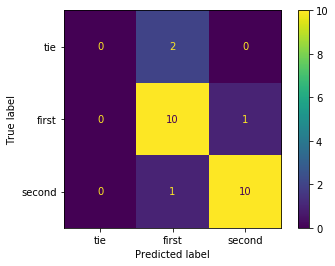

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.77      0.91      0.83        11
           2       0.91      0.91      0.91        11

    accuracy                           0.83        24
   macro avg       0.56      0.61      0.58        24
weighted avg       0.77      0.83      0.80        24



c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [21]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(
    clf, X_test, Y_test,
    labels=[0, 1, 2],
    display_labels=['tie', 'first', 'second'],
    #normalize='true'
)
plt.show()

conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

from sklearn.metrics import classification_report
print(str(classification_report(y_true=Y_test, y_pred=y_pred)))

## 2.3. PCA de variables + clúster

In [22]:
team_features = ['7mPGoals', '7mPMissed', '6mCGoals', '6mCMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'FTOGoals', 'FTOMissed', '9mGoals', '9mMissed', 'RC', '2M', 'AS', 'R7', 'ST', 'BS', 'P7', 'TO', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

train_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,A_FBGoals,A_FBMissed,A_FTOGoals,A_FTOMissed,A_9mGoals,A_9mMissed,A_RC,A_2M,A_AS,A_R7,A_ST,A_BS,A_P7,A_TO,A_cluster,B_7mPGoals,B_7mPMissed,B_6mCGoals,B_6mCMissed,B_WingGoals,B_WingMissed,B_BTGoals,B_BTMissed,B_FBGoals,B_FBMissed,B_FTOGoals,B_FTOMissed,B_9mGoals,B_9mMissed,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result
0,MNE,RUS,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,2
1,RUS,MNE,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,1
2,FRA,ESP,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,1
3,ESP,FRA,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,2
4,FRA,RUS,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,0
5,RUS,FRA,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,0
6,DEN,SWE,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
7,SWE,DEN,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,2
8,MNE,SWE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
9,SWE,MNE,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,2


In [23]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3, 4, 5, 6]

X = train_df[match_features]

for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=20)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 31.54% [0.16113247 0.15426562]
[scaler=Standard, n=3] Explained variance: 45.20% [0.16113247 0.15426562 0.13658893]
[scaler=Standard, n=4] Explained variance: 55.23% [0.16113247 0.15426562 0.13658893 0.1003557 ]
[scaler=Standard, n=5] Explained variance: 62.63% [0.16113247 0.15426562 0.13658893 0.1003557  0.07399882]
[scaler=Standard, n=6] Explained variance: 68.22% [0.16113247 0.15426562 0.13658893 0.1003557  0.07399882 0.055876  ]
[scaler=MinMax, n=2] Explained variance: 30.02% [0.15591538 0.14430192]
[scaler=MinMax, n=3] Explained variance: 44.30% [0.15591538 0.14430192 0.14281267]
[scaler=MinMax, n=4] Explained variance: 54.14% [0.15591538 0.14430192 0.14281267 0.09834249]
[scaler=MinMax, n=5] Explained variance: 62.19% [0.15591538 0.14430192 0.14281267 0.09834249 0.08050922]
[scaler=MinMax, n=6] Explained variance: 67.39% [0.15591538 0.14430192 0.14281267 0.09834249 0.08050922 0.05200996]


In [24]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(train_df[match_features])

from sklearn.decomposition import PCA
estimator = PCA(n_components = 6)
X_train = estimator.fit_transform(X_scaled)

Y_train = train_df['result']


X_scaled = scaler.transform(test_df[match_features])
X_test = estimator.transform(X_scaled)

Y_test = test_df['result']

explained_variance = estimator.explained_variance_ratio_.cumsum()[-1]
print("Total explained variance:", explained_variance)

Total explained variance: 0.6822175478384069


### 2.3.1. k-NN

Probamos un clasificador basado en los 'k' vecinos más cercanos. Vamos a estudiar primero la parametrización del algoritmo para ver qué sería lo óptimo en este caso.

In [25]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

best_params = None
best_accuracy = 0

for k in range(2, 15):
    for weights in ['uniform', 'distance']:
        print(f"k-NN (k={k}, weights='{weights}')")
        
        clf = neighbors.KNeighborsClassifier(k, weights=weights)
        clf.fit(X_train, Y_train)
        
        y_pred = clf.predict(X_test)
        
        conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
        accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
        
        if best_params is None or accuracy > best_accuracy:
            best_params = (k, weights)
            best_accuracy = accuracy

print(f"Best accuracy was {accuracy}, with k={best_params[0]} and weights='{best_params[1]}'")

k-NN (k=2, weights='uniform')
k-NN (k=2, weights='distance')
k-NN (k=3, weights='uniform')
k-NN (k=3, weights='distance')
k-NN (k=4, weights='uniform')
k-NN (k=4, weights='distance')
k-NN (k=5, weights='uniform')
k-NN (k=5, weights='distance')
k-NN (k=6, weights='uniform')
k-NN (k=6, weights='distance')
k-NN (k=7, weights='uniform')
k-NN (k=7, weights='distance')
k-NN (k=8, weights='uniform')
k-NN (k=8, weights='distance')
k-NN (k=9, weights='uniform')
k-NN (k=9, weights='distance')
k-NN (k=10, weights='uniform')
k-NN (k=10, weights='distance')
k-NN (k=11, weights='uniform')
k-NN (k=11, weights='distance')
k-NN (k=12, weights='uniform')
k-NN (k=12, weights='distance')
k-NN (k=13, weights='uniform')
k-NN (k=13, weights='distance')
k-NN (k=14, weights='uniform')
k-NN (k=14, weights='distance')
Best accuracy was 0.8333333333333334, with k=4 and weights='distance'


En este caso, el porcentaje de acierto es superior al caso anterior, pero sigue siendo inferior que en la primera propuesta (83.34% < 87.5%).

Consideramos que estos resultados tienen sentido, ya que en el primer caso nos quedábamos únicamente con 3 variables para cada equipo en cada partido, siendo estas las más representativas del equipo según el análisis que se realizó en el trabajo anterior. Es de esperar, por tanto, que esa combinación de variables dé lugar a un mejor resultado.

### 2.3.2. SVM

In [26]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC()

In [27]:
y_pred = clf.predict(X_test)
test_df['svm'] = y_pred

test_df[['teamA', 'teamB', 'result', 'svm']]

,teamA,teamB,result,svm
0,FRA,MNE,1,1
1,DEN,SLO,1,1
2,SLO,FRA,2,2
3,MNE,DEN,2,2
4,MNE,SLO,1,1
5,FRA,DEN,1,1
6,RUS,ESP,1,2
7,SWE,CZE,1,1
8,CZE,RUS,2,2
9,ESP,SWE,0,1


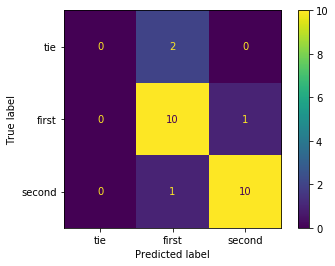

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.77      0.91      0.83        11
           2       0.91      0.91      0.91        11

    accuracy                           0.83        24
   macro avg       0.56      0.61      0.58        24
weighted avg       0.77      0.83      0.80        24



c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [28]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(
    clf, X_test, Y_test,
    labels=[0, 1, 2],
    display_labels=['tie', 'first', 'second'],
    #normalize='true'
)
plt.show()

conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

from sklearn.metrics import classification_report
print(str(classification_report(y_true=Y_test, y_pred=y_pred)))

# 3. Pronóstico

Habiendo decidido ya qué modelo resultaba mejor en la sección anterior, procedemos a aplicarlo para intentar calcular el resultado de algunos partidos que no tuvieron lugar en el Campeonato.

In [29]:
# Volvemos a definir el mejor modelo encontrado

team_features = ['PC1', 'PC2', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

X_train = train_df[match_features]
Y_train = train_df['result']

X_test = test_df[match_features]
Y_test = test_df['result']


from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(4, weights='uniform')
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
test_df['knn'] = y_pred


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)


test_df[['teamA', 'teamB', 'result', 'knn']]

Accuracy: 0.875


,teamA,teamB,result,knn
0,FRA,MNE,1,1
1,DEN,SLO,1,1
2,SLO,FRA,2,2
3,MNE,DEN,2,2
4,MNE,SLO,1,1
5,FRA,DEN,1,1
6,RUS,ESP,1,1
7,SWE,CZE,1,1
8,CZE,RUS,2,2
9,ESP,SWE,0,1


In [30]:
nonplayed_matches = [
    ['España', 'Hungría'],
    ['Croacia', 'España'],
    ['Dinamarca', 'Países Bajos'],
    ['República Checa', 'Polonia'],
    ['Francia', 'Alemania']
]

nonplayed_matches = [
    [country_abbr(teamA), country_abbr(teamB)]
    for teamA, teamB in nonplayed_matches
]
nonplayed_matches

[['ESP', 'HUN'],
 ['CRO', 'ESP'],
 ['DEN', 'NED'],
 ['CZE', 'POL'],
 ['FRA', 'GER']]

In [31]:
test_df = generate_data(nonplayed_matches, teams_df, team_features)
test_df

,teamA,teamB,A_PC1,A_PC2,A_cluster,B_PC1,B_PC2,B_cluster,result
0,ESP,HUN,-0.934444,-0.324208,1.0,-0.210540,-1.356587,4.0,-1
1,CRO,ESP,-3.007976,4.226142,3.0,-0.934444,-0.324208,1.0,-1
2,DEN,NED,-3.174269,0.759901,3.0,-2.727188,-1.817280,1.0,-1
3,CZE,POL,5.047346,0.364696,0.0,5.198268,-0.543011,0.0,-1
4,FRA,GER,-4.118907,1.369064,3.0,-1.206175,0.056285,1.0,-1


In [32]:
test_df['result'] = clf.predict(test_df[match_features])
test_df[['teamA', 'teamB', 'result']]

,teamA,teamB,result
0,ESP,HUN,1
1,CRO,ESP,1
2,DEN,NED,1
3,CZE,POL,1
4,FRA,GER,1


Comprobamos que si invertimos el orden de los equipos, el ganador resultante del pronóstico es el mismo.

In [33]:
nonplayed_matches = [
    ['Hungría', 'España'],
    ['España', 'Croacia'],
    ['Países Bajos', 'Dinamarca'],
    ['Polonia', 'República Checa'],
    ['Alemania', 'Francia']
]

nonplayed_matches = [
    [country_abbr(teamA), country_abbr(teamB)]
    for teamA, teamB in nonplayed_matches
]

test_df = generate_data(nonplayed_matches, teams_df, team_features)

test_df['result'] = clf.predict(test_df[match_features])
test_df[['teamA', 'teamB', 'result']]

,teamA,teamB,result
0,HUN,ESP,2
1,ESP,CRO,2
2,NED,DEN,2
3,POL,CZE,2
4,GER,FRA,2
